In [1]:
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["font.size"] = "10"

In [2]:
data    = pd.read_csv("test/ubuntu/individual-benchmarks-new.csv")
data_lg = pd.read_csv("test-lambda-groups/ubuntu/individual-benchmarks-new.csv")
data_pg = pd.read_csv("test-pg-lambda-groups/ubuntu/individual-benchmarks-new.csv")
data_r8 = pd.read_csv("test-r8/ubuntu/individual-benchmarks-new.csv")

In [3]:
data["transformation"] = "original"
data_lg["transformation"] = "pg_lambda_merging"
data_pg["transformation"] = "pg_shrinking_lambda_merging_optimisation"
data_r8["transformation"] = "r8_shrinking_optimisation"

In [4]:
df = pd.concat([data, data_lg, data_pg, data_r8], ignore_index=True)

In [5]:
def get_arity_from_benchmark(benchmark):
    benchmark = benchmark.replace("InstantiationsAnd", "")
    benchmark = benchmark.replace("test.MyBenchmark.emptyClosure", "")
    benchmark = benchmark.replace("Arguments3MillionCalls", "")
    try:
        arity = int(benchmark)
        return arity
    except Exception:
        return 0

In [6]:
def get_closure_size_from_benchmark(benchmark):
    benchmark = benchmark.replace("InstantiationsAnd", "")
    benchmark = benchmark.replace("test.MyBenchmark.closure", "")
    benchmark = benchmark.replace("FreeVariables3MillionCalls", "")
    benchmark = benchmark.replace("FreeVariables3MillionInstantiations", "")
    try:
        closure_size = int(benchmark)
        return closure_size
    except Exception as exc:
        return 0

In [7]:
def add_test_type(data):
    data["closure_test"] = data["benchmark"].apply(lambda val: val.startswith("test.MyBenchmark.closure") and "FreeVariables" in val)
    data["arity_test"] = data["benchmark"].apply(lambda val: val.startswith("test.MyBenchmark.emptyClosure") and "Arguments3Million" in val)
    data["instantiation_test"] = data["benchmark"].apply(lambda val: "Instantiations" in val)
    data["invocation_test"] = data["benchmark"].apply(lambda val: "Calls" in val)

In [8]:
def add_arity(data):
    data["arity"] = data["benchmark"].apply(get_arity_from_benchmark)

In [9]:
def add_closure_size(data):
    data["closure_size"] = data["benchmark"].apply(get_closure_size_from_benchmark)

In [10]:
add_test_type(df)
add_arity(df)
add_closure_size(df)

In [11]:
test_df = df.query("iteration_type == 'test'")

transformation
original                                    AxesSubplot(0.125,0.125;0.775x0.755)
pg_lambda_merging                           AxesSubplot(0.125,0.125;0.775x0.755)
pg_shrinking_lambda_merging_optimisation    AxesSubplot(0.125,0.125;0.775x0.755)
r8_shrinking_optimisation                   AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

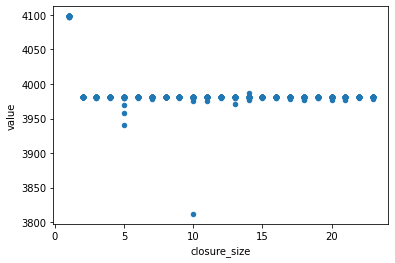

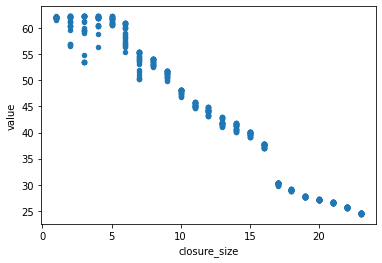

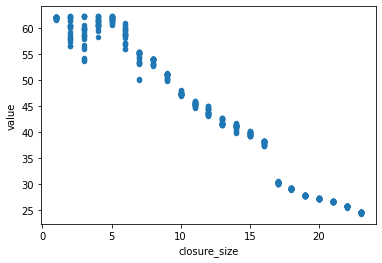

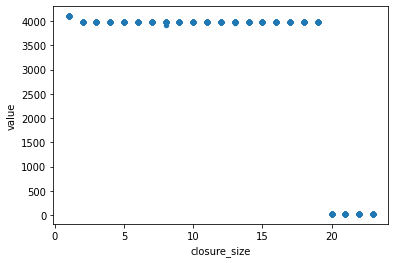

In [12]:
test_df.query("closure_test and invocation_test and not instantiation_test").groupby(by="transformation").plot.scatter(x="closure_size", y="value")

original
pg_lambda_merging
pg_shrinking_lambda_merging_optimisation
r8_shrinking_optimisation


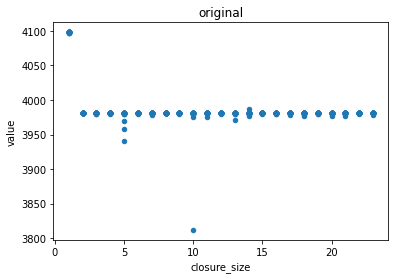

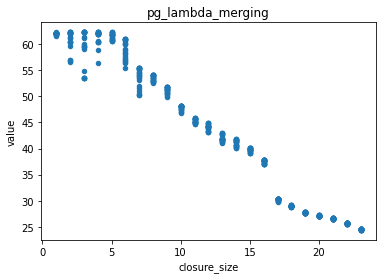

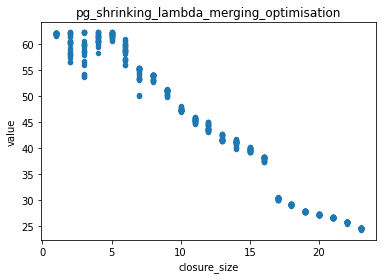

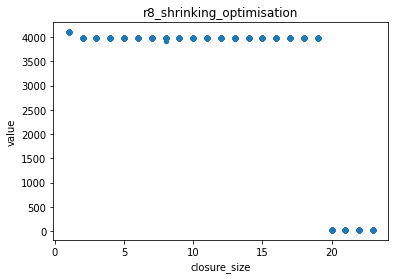

In [13]:
for transformation in ["original", "pg_lambda_merging", "pg_shrinking_lambda_merging_optimisation", "r8_shrinking_optimisation"]:
    print(transformation)
    ax = test_df.query(f"closure_test and invocation_test and not instantiation_test and transformation == '{transformation}'").plot.scatter(x="closure_size", y="value")
    ax.set_title(transformation)

In [82]:
def thousand_dot_formatter(value: str) -> str:
    # expecting comma as decimal point
    parts = value.split(",")
    before_comma = parts[0]
    if len(parts) == 2:
        after_comma = f",{parts[1]}"
    elif len(parts) > 2:
        raise ValueError("The thousand_dot_formatter expects values that are comma formatted or integers.")
    else:
        after_comma = ""
    value_before_comma = int(before_comma)
    end_index = len(before_comma)
    new_before_comma = ""
    while value_before_comma >= 1000:
        end = f".{new_before_comma}" if new_before_comma != "" else f"{new_before_comma}"
        new_before_comma = f"{before_comma[end_index-3:end_index]}{end}"
        value_before_comma = value_before_comma / 1000
        end_index -= 3
    start = f"{before_comma[:end_index]}"
    if new_before_comma == "":
        new_before_comma = start
    else:
        new_before_comma = f"{start}.{new_before_comma}"
    return f"{new_before_comma}{after_comma}"

In [48]:
def comma_formatter(val):
    return str(val).replace(".", ",")

In [51]:
def get_yaxis_formatter(round_dec, y_unit):
    def yaxis_formatter(val, val2):
        val = round(val) if round_dec == 0 else round(val, round_dec)
        return f"{thousand_dot_formatter(comma_formatter(val))} {y_unit}"
    return yaxis_formatter

In [14]:
name_to_file_name = {"original": "before-lambda-merging", "pg_lambda_merging": "after-lambda-merging", "pg_shrinking_lambda_merging_optimisation": "pg", "r8_shrinking_optimisation": "r8"}

In [52]:
def plot_performance_results(query, x_label, y_label, base_file_name, x_column, y_column="value", y_unit = "ops/s", round_dec=0, savefig=True, transformations=["original", "pg_lambda_merging", "pg_shrinking_lambda_merging_optimisation", "r8_shrinking_optimisation"]):
    for transformation in transformations:
        value_aggs = test_df.query(f"{query} and transformation == '{transformation}'").groupby(by=x_column)[[y_column]].describe().reset_index()
        ax = value_aggs.plot.scatter(x=x_column, y=(y_column, "mean"), figsize=(5.5082/2, 5.5082/2))
        ax.errorbar(value_aggs[x_column], value_aggs[y_column]["mean"], yerr=value_aggs[y_column]["std"], fmt="o", ecolor="black", capsize=2)
        #ax.set_title(transformation.replace("_", " "))
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        ax.yaxis.set_major_formatter(get_yaxis_formatter(round_dec, y_unit))
        #plt.scatter(value_aggs["closure_size"], value_aggs["value"]["50%"], color="red") #, yerr=("value", "std"))
        if savefig:
            plt.savefig(f"figures/{base_file_name}-{name_to_file_name[transformation]}-nl.pdf", bbox_inches='tight')

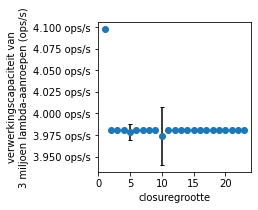

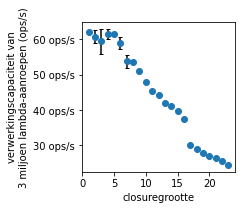

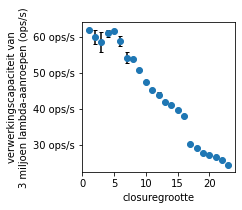

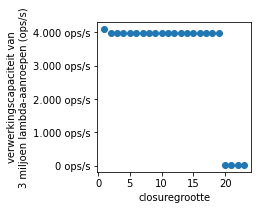

In [83]:
plot_performance_results(query="closure_test and invocation_test and not instantiation_test", x_label="closuregrootte", y_label="verwerkingscapaciteit van\n3 miljoen lambda-aanroepen (ops/s)", base_file_name="average-throughput-invocation-closure", x_column="closure_size")

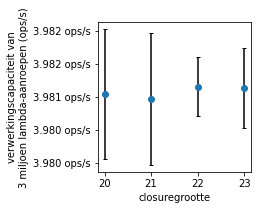

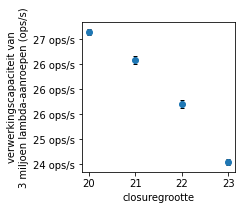

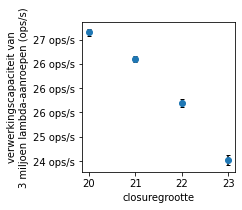

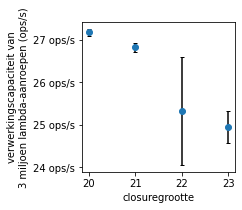

In [54]:
plot_performance_results(savefig=False, query="closure_test and invocation_test and not instantiation_test and closure_size >= 20", x_label="closuregrootte", y_label="verwerkingscapaciteit van\n3 miljoen lambda-aanroepen (ops/s)", base_file_name="average-throughput-invocation-closure", x_column="closure_size")

original
pg_lambda_merging
pg_shrinking_lambda_merging_optimisation
r8_shrinking_optimisation


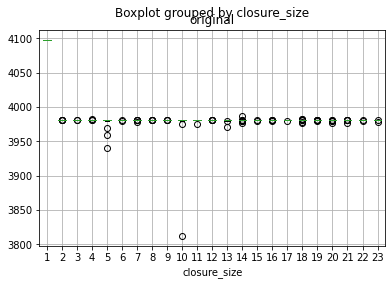

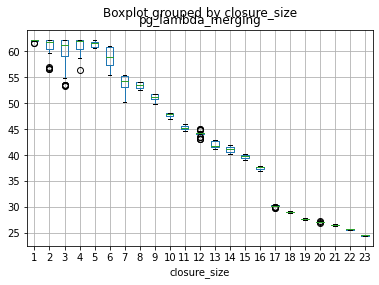

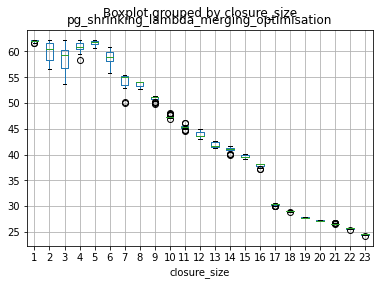

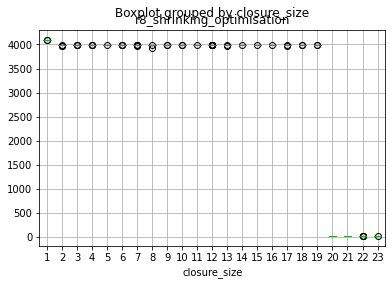

In [55]:
for transformation in ["original", "pg_lambda_merging", "pg_shrinking_lambda_merging_optimisation", "r8_shrinking_optimisation"]:
    print(transformation)
    ax = test_df.query(f"closure_test and invocation_test and not instantiation_test and transformation == '{transformation}' and iteration_type == 'test'").boxplot(by="closure_size", column="value")
    ax.set_title(transformation)

original
pg_lambda_merging
pg_shrinking_lambda_merging_optimisation
r8_shrinking_optimisation


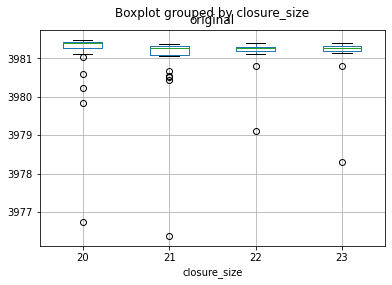

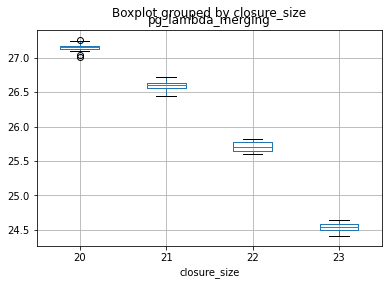

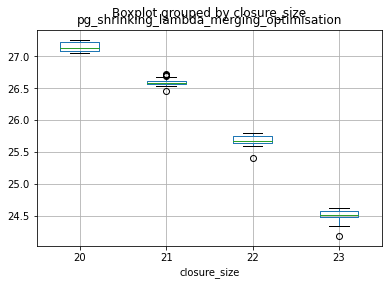

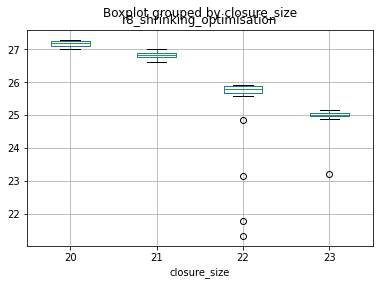

In [56]:
for transformation in ["original", "pg_lambda_merging", "pg_shrinking_lambda_merging_optimisation", "r8_shrinking_optimisation"]:
    print(transformation)
    ax = test_df.query(f"closure_test and invocation_test and not instantiation_test and transformation == '{transformation}' and iteration_type == 'test' and closure_size >= 20").boxplot(by="closure_size", column="value")
    ax.set_title(transformation)

r8_shrinking_optimisation    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

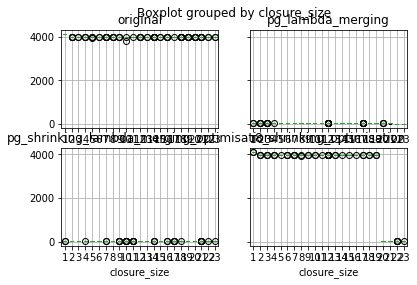

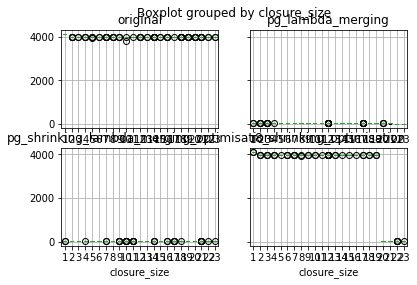

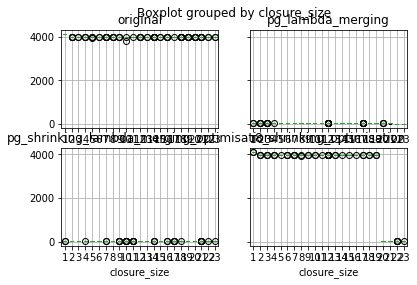

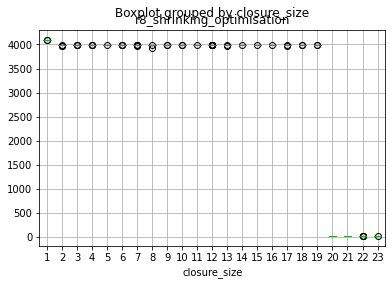

In [57]:

test_df.query("closure_test and invocation_test and not instantiation_test").groupby(by="transformation").boxplot(by="closure_size", column="value")
test_df.query("closure_test and invocation_test and not instantiation_test").groupby(by="transformation").boxplot(by="closure_size", column="value")
test_df.query("closure_test and invocation_test and not instantiation_test").groupby(by="transformation").boxplot(by="closure_size", column="value")
test_df.query("closure_test and invocation_test and not instantiation_test and transformation == 'r8_shrinking_optimisation'").groupby(by="transformation").boxplot(by="closure_size", column="value")

transformation
original                                    AxesSubplot(0.125,0.125;0.775x0.755)
pg_lambda_merging                           AxesSubplot(0.125,0.125;0.775x0.755)
pg_shrinking_lambda_merging_optimisation    AxesSubplot(0.125,0.125;0.775x0.755)
r8_shrinking_optimisation                   AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

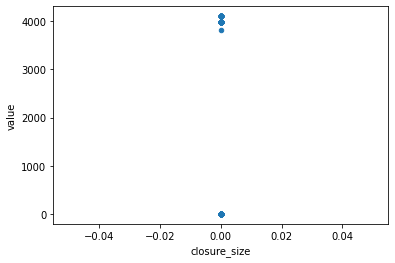

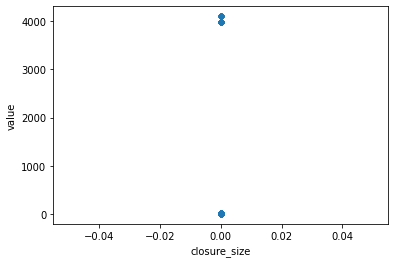

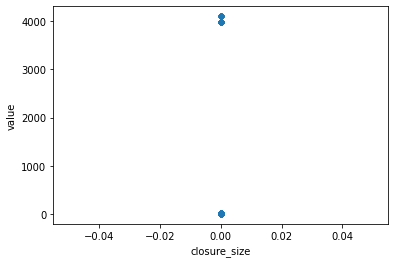

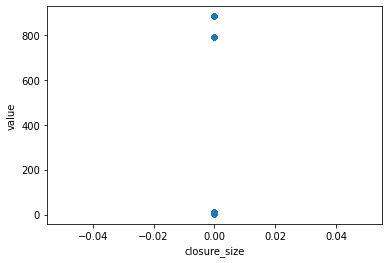

In [58]:
test_df.query("arity_test and invocation_test and not instantiation_test").groupby(by="transformation").plot.scatter(x="closure_size", y="value")

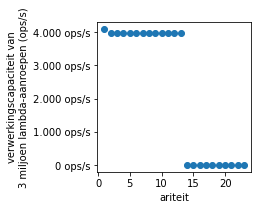

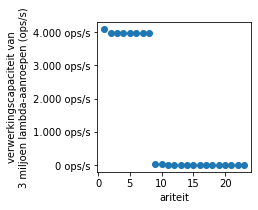

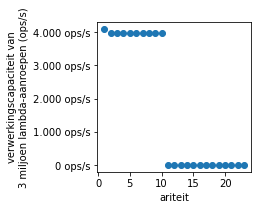

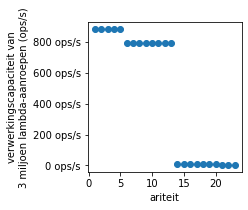

In [84]:
#test_df.query("arity_test and invocation_test and not instantiation_test").groupby(by="transformation").plot.scatter(x="arity", y="value")
plot_performance_results(query="arity_test and invocation_test and not instantiation_test", x_label="ariteit", y_label="verwerkingscapaciteit van\n3 miljoen lambda-aanroepen (ops/s)", base_file_name="average-throughput-invocation-arity", x_column="arity")

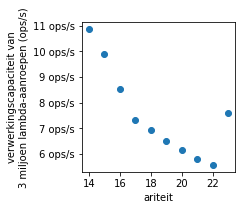

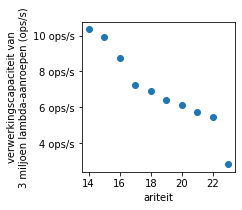

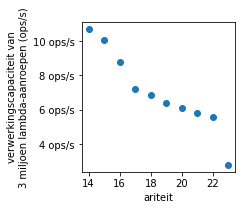

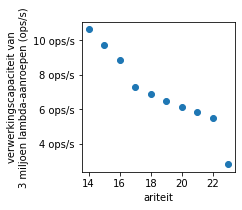

In [60]:
plot_performance_results(savefig=False, query="arity_test and invocation_test and not instantiation_test and arity >= 14", x_label="ariteit", y_label="verwerkingscapaciteit van\n3 miljoen lambda-aanroepen (ops/s)", base_file_name="average-throughput-invocation-arity", x_column="arity")

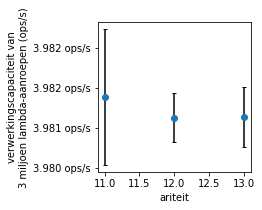

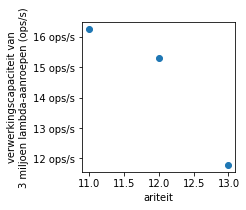

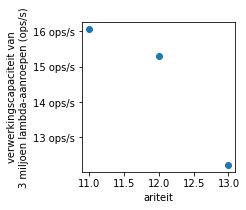

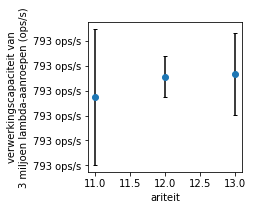

In [61]:
plot_performance_results(savefig=False, query="arity_test and invocation_test and not instantiation_test and 10 < arity and arity < 14", x_label="ariteit", y_label="verwerkingscapaciteit van\n3 miljoen lambda-aanroepen (ops/s)", base_file_name="average-throughput-invocation-arity", x_column="arity")

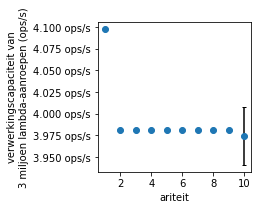

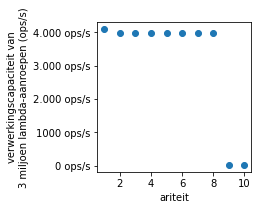

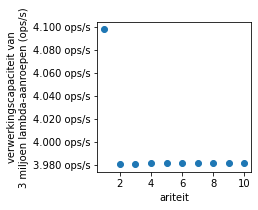

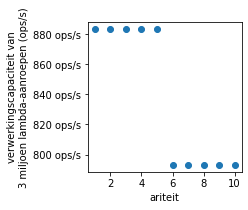

In [62]:
plot_performance_results(savefig=False, query="arity_test and invocation_test and not instantiation_test and arity <= 10", x_label="ariteit", y_label="verwerkingscapaciteit van\n3 miljoen lambda-aanroepen (ops/s)", base_file_name="average-throughput-invocation-arity", x_column="arity")

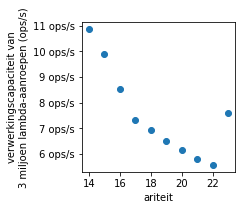

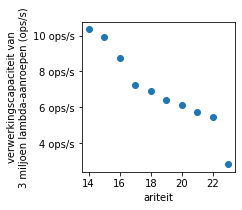

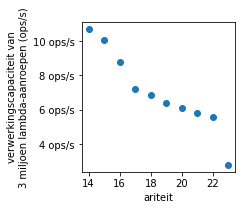

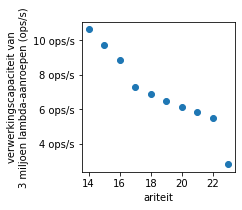

In [63]:
plot_performance_results(query="arity_test and invocation_test and not instantiation_test and arity > 13", x_label="ariteit", y_label="verwerkingscapaciteit van\n3 miljoen lambda-aanroepen (ops/s)", base_file_name="individual-performance-benchmark-results-arity-14+-call", x_column="arity")

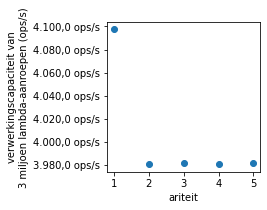

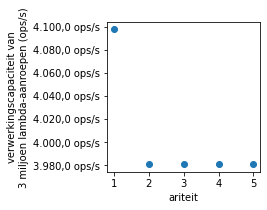

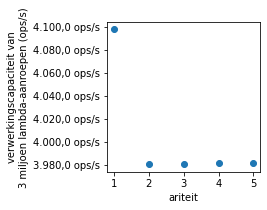

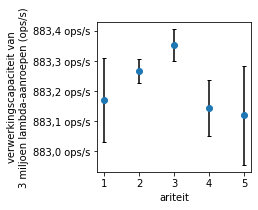

In [64]:
plot_performance_results(query="arity_test and invocation_test and not instantiation_test and arity < 6", x_label="ariteit", y_label="verwerkingscapaciteit van\n3 miljoen lambda-aanroepen (ops/s)", base_file_name="individual-performance-benchmark-results-arity-1-5-call", x_column="arity", round_dec=2)

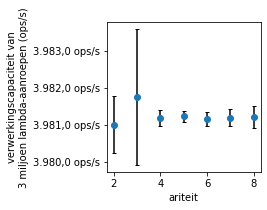

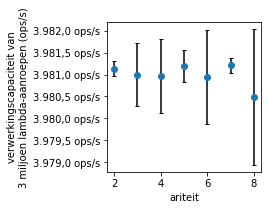

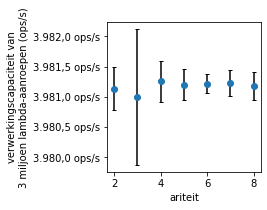

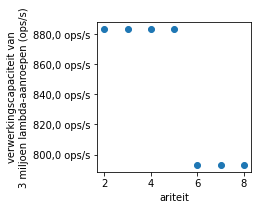

In [65]:
plot_performance_results(query="arity_test and invocation_test and not instantiation_test and arity >= 2 and arity <= 8", x_label="ariteit", y_label="verwerkingscapaciteit van\n3 miljoen lambda-aanroepen (ops/s)", base_file_name="individual-performance-benchmark-results-arity-2-8-call", x_column="arity", round_dec=2)

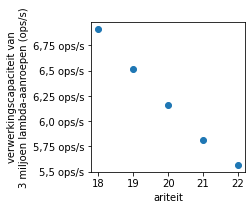

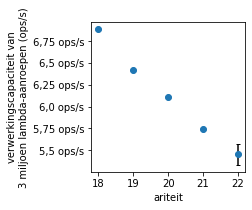

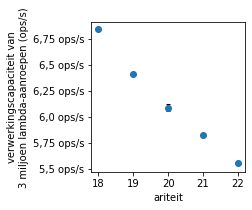

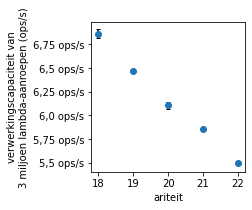

In [66]:
plot_performance_results(query="arity_test and invocation_test and not instantiation_test and arity >= 18 and arity <= 22", x_label="ariteit", y_label="verwerkingscapaciteit van\n3 miljoen lambda-aanroepen (ops/s)", base_file_name="individual-performance-benchmark-results-arity-18-22-call", x_column="arity", round_dec=2)

transformation
original                                    AxesSubplot(0.125,0.125;0.775x0.755)
pg_lambda_merging                           AxesSubplot(0.125,0.125;0.775x0.755)
pg_shrinking_lambda_merging_optimisation    AxesSubplot(0.125,0.125;0.775x0.755)
r8_shrinking_optimisation                   AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

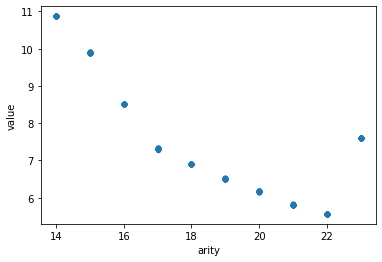

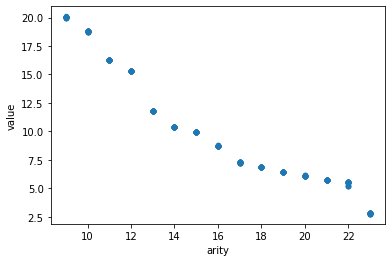

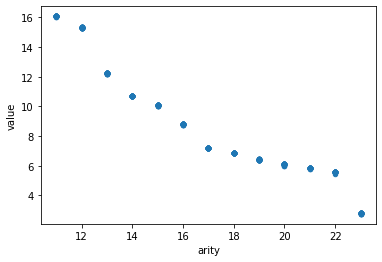

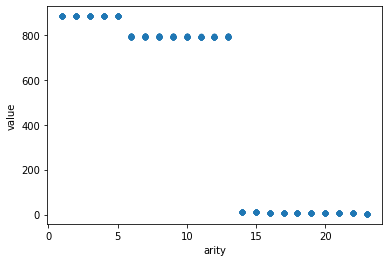

In [67]:
test_df.query("arity_test and invocation_test and not instantiation_test and value < 3000").groupby(by="transformation").plot.scatter(x="arity", y="value")

transformation
original                                    AxesSubplot(0.125,0.125;0.775x0.755)
pg_lambda_merging                           AxesSubplot(0.125,0.125;0.775x0.755)
pg_shrinking_lambda_merging_optimisation    AxesSubplot(0.125,0.125;0.775x0.755)
r8_shrinking_optimisation                   AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

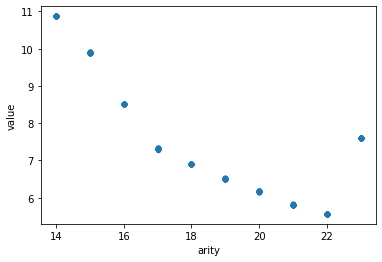

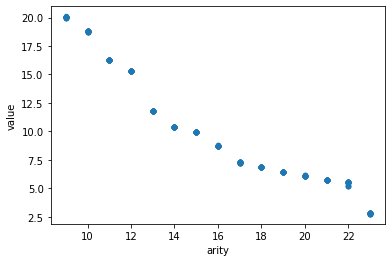

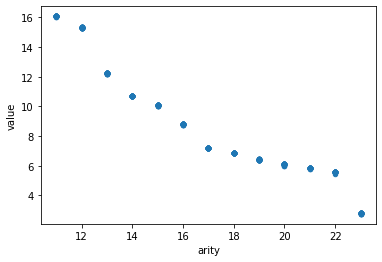

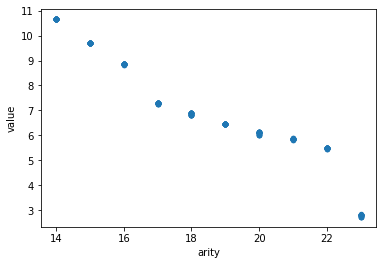

In [68]:
test_df.query("arity_test and invocation_test and not instantiation_test and value < 100").groupby(by="transformation").plot.scatter(x="arity", y="value")

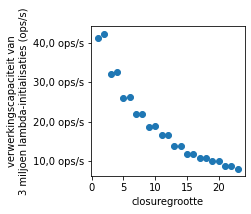

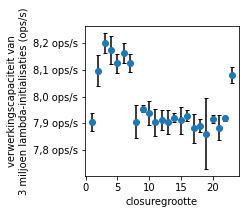

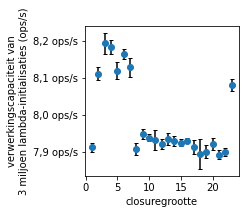

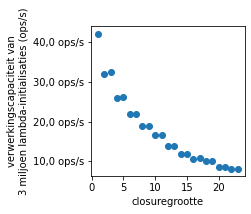

In [69]:
#test_df.query("closure_test and not invocation_test and instantiation_test").groupby(by="transformation").plot.scatter(x="closure_size", y="value")
plot_performance_results(query="closure_test and not invocation_test and instantiation_test and closure_size > 0", x_label="closuregrootte", y_label="verwerkingscapaciteit van\n3 miljoen lambda-initialisaties (ops/s)", base_file_name="average-throughput-instantiation", x_column="closure_size", round_dec=2)

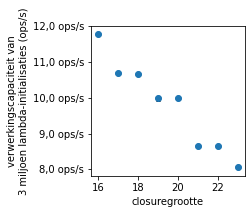

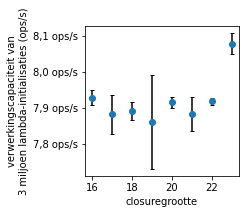

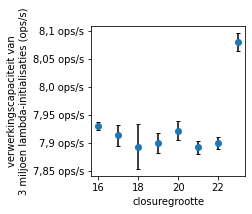

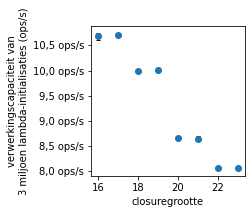

In [70]:
plot_performance_results(savefig=False, query="closure_test and not invocation_test and instantiation_test and closure_size > 15", x_label="closuregrootte", y_label="verwerkingscapaciteit van\n3 miljoen lambda-initialisaties (ops/s)", base_file_name="average-throughput-instantiation", x_column="closure_size", round_dec=2)

In [71]:
test_df.query("transformation == 'r8_shrinking_optimisation' and instantiation_test")

,benchmark,benchmark_mode,fork,total_forks,iteration,iteration_type,value,metric,transformation,closure_test,arity_test,instantiation_test,invocation_test,arity,closure_size
12655,test.MyBenchmark.closure10FreeVariables3Millio...,throughput,1,5,1,test,16.468,ops/s,r8_shrinking_optimisation,True,False,True,False,0,10
12656,test.MyBenchmark.closure10FreeVariables3Millio...,throughput,1,5,2,test,16.476,ops/s,r8_shrinking_optimisation,True,False,True,False,0,10
12657,test.MyBenchmark.closure10FreeVariables3Millio...,throughput,1,5,3,test,16.481,ops/s,r8_shrinking_optimisation,True,False,True,False,0,10
12658,test.MyBenchmark.closure10FreeVariables3Millio...,throughput,1,5,4,test,16.477,ops/s,r8_shrinking_optimisation,True,False,True,False,0,10
12659,test.MyBenchmark.closure10FreeVariables3Millio...,throughput,1,5,5,test,16.498,ops/s,r8_shrinking_optimisation,True,False,True,False,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13795,test.MyBenchmark.closure9FreeVariables3Million...,throughput,5,5,1,test,18.803,ops/s,r8_shrinking_optimisation,True,False,True,False,0,9
13796,test.MyBenchmark.closure9FreeVariables3Million...,throughput,5,5,2,test,18.812,ops/s,r8_shrinking_optimisation,True,False,True,False,0,9
13797,test.MyBenchmark.closure9FreeVariables3Million...,throughput,5,5,3,test,18.801,ops/s,r8_shrinking_optimisation,True,False,True,False,0,9
13798,test.MyBenchmark.closure9FreeVariables3Million...,throughput,5,5,4,test,18.806,ops/s,r8_shrinking_optimisation,True,False,True,False,0,9


In [72]:
query = "instantiation_test"
column = "value"
for transformation in ["original", "pg_lambda_merging", "pg_shrinking_lambda_merging_optimisation", "r8_shrinking_optimisation"]:
        value_aggs = test_df.query(f"{query} and transformation == '{transformation}'")[[column]].describe().reset_index()
        print(transformation)
        print(value_aggs, end="\n\n")

original
   index       value
0  count  575.000000
1   mean   18.799760
2    std   10.015532
3    min    7.893000
4    25%   10.680000
5    50%   16.629000
6    75%   25.936500
7    max   42.449000

pg_lambda_merging
   index       value
0  count  575.000000
1   mean    7.978638
2    std    0.118601
3    min    7.388000
4    25%    7.909000
5    50%    7.932000
6    75%    8.093000
7    max    8.251000

pg_shrinking_lambda_merging_optimisation
   index       value
0  count  575.000000
1   mean    7.986692
2    std    0.106982
3    min    7.704000
4    25%    7.910000
5    50%    7.932000
6    75%    8.094000
7    max    8.236000

r8_shrinking_optimisation
   index       value
0  count  575.000000
1   mean   17.373588
2    std    8.999866
3    min    8.041000
4    25%   10.044500
5    50%   13.836000
6    75%   21.912500
7    max   42.489000



In [73]:
query = "invocation_test"
column = "value"
for transformation in ["original", "pg_lambda_merging", "pg_shrinking_lambda_merging_optimisation", "r8_shrinking_optimisation"]:
        value_aggs = test_df.query(f"{query} and transformation == '{transformation}'")[[column]].describe().reset_index()
        print(transformation)
        print(value_aggs, end="\n\n")

original
   index        value
0  count  1150.000000
1   mean  3122.012016
2    std  1642.383969
3    min     5.566000
4    25%  3980.256000
5    50%  3981.188000
6    75%  3981.319000
7    max  4097.981000

pg_lambda_merging
   index        value
0  count  1150.000000
1   mean   720.174204
2    std  1503.704859
3    min     2.748000
4    25%    15.318250
5    50%    38.466000
6    75%    61.193500
7    max  4098.248000

pg_shrinking_lambda_merging_optimisation
   index        value
0  count  1150.000000
1   mean   892.419626
2    std  1634.950904
3    min     2.756000
4    25%    15.309000
5    50%    41.422500
6    75%    62.012750
7    max  4098.032000

r8_shrinking_optimisation
   index        value
0  count  1150.000000
1   mean  1884.585183
2    std  1792.177087
3    min     2.731000
4    25%    25.807750
5    50%   883.077500
6    75%  3981.182000
7    max  4098.021000



In [80]:
892.419626 * 3_000_000 * 10**(-7)

267.7258878

In [81]:
1884.585183 * 3_000_000 * 10**(-7)

565.3755549

In [85]:
(1884.585183 * 3_000_000 * 10**(-7)) / (892.419626 * 3_000_000 * 10**(-7))

2.1117702122342163

In [75]:
query = "invocation_test and closure_test"
column = "value"
for transformation in ["original", "pg_lambda_merging", "pg_shrinking_lambda_merging_optimisation", "r8_shrinking_optimisation"]:
        value_aggs = test_df.query(f"{query} and transformation == '{transformation}'")[[column]].describe().reset_index()
        print(transformation)
        print(value_aggs, end="\n\n")

original
   index        value
0  count   575.000000
1   mean  3985.733221
2    std    25.010230
3    min  3812.005000
4    25%  3981.140500
5    50%  3981.258000
6    75%  3981.334000
7    max  4097.868000

pg_lambda_merging
   index       value
0  count  575.000000
1   mean   43.979144
2    std   13.225163
3    min   24.408000
4    25%   29.087000
5    50%   44.203000
6    75%   55.399000
7    max   62.266000

pg_shrinking_lambda_merging_optimisation
   index       value
0  count  575.000000
1   mean   43.874409
2    std   13.095343
3    min   24.186000
4    25%   29.113000
5    50%   43.647000
6    75%   55.912500
7    max   62.267000

r8_shrinking_optimisation
   index        value
0  count   575.000000
1   mean  3298.245071
2    std  1502.874470
3    min    21.321000
4    25%  3980.760000
5    50%  3981.182000
6    75%  3981.349000
7    max  4098.021000



In [87]:
43.874409 * 3_000_000 * 10**(-8)

1.31623227

In [86]:
3298.245071 * 3_000_000 * 10**(-9)

9.894735213

In [88]:
3298.245071 / 43.874409

75.17468944140079